In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))
import nltk
nltk.download('stopwords')
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyLDAvis.sklearn
import pyLDAvis
import dask.bag as db
import json
import re
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maoyiting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preprocessing

For **multi-label classification** we will only need document id, categories and abstract. So let's exract those fields, discard everything else and convert to a pandas dataframe.

In [2]:
SEED = 4
docs = db.read_text('/Users/maoyiting/repository/M4R/arxiv-data/arxiv-metadata-oai-snapshot.json').map(json.loads)

In [5]:
# count total number
#docs.count().compute()

In [3]:
# Submissions by datetime
get_latest_version = lambda x: x['versions'][-1]['created']

In [4]:
# get only necessary fields
trim = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'].split(' '),
                  'abstract':x['abstract']}

# filter for papers published on or after 2021-01-01
columns = ['id','category','abstract']
docs_df = (docs
             .filter(lambda x: int(get_latest_version(x).split(' ')[3]) > 2020)
             .map(trim)
             .compute())

# convert to pandas
docs_df = pd.DataFrame(docs_df)

# add general category. we are going to use as our target variable
docs_df['general_category'] = docs_df.category.apply(lambda x:[a.split('.')[0] for a in x])

In [5]:
# filter for papers in 'math' or 'physics' area
docs_df_2=docs_df[(docs_df.general_category.apply(lambda x: 'math' in x )==True)|(docs_df.general_category.apply(lambda x: 'physics' in x )==True)]

In [6]:
# filter for papers only in 'math' or 'physics' area
docs_df_3 = docs_df_2[(docs_df_2.general_category.apply(lambda x: len(x) )==1)]

In [7]:
docs_df_3

,id,title,category,abstract,general_category
1,0706.2239,Infinitesimal Castelnuovo Theory in Abelian Va...,[math.AG],The purpose of this article is to show that ...,[math]
4,0707.4657,The Informational Conception and Basic Physics,[physics.gen-ph],"In our previous arXiv papers (""The Informati...",[physics]
5,0709.2797,"Comments On "" Orbits of automorphism groups of...",[math.AC],Let $R$ be a commutative $k-$algebra over a ...,[math]
6,0710.1594,Time Dilation and the Equivalence of Inertial ...,[physics.gen-ph],It is well known that simultaneity within an...,[physics]
7,0710.2625,On two problems concerning topological centers,[math.DS],Let G be an infinite discrete group and bG i...,[math]
...,...,...,...,...,...
176328,physics/0505086,Social Behaviour of Agents: Capital Markets an...,[physics.soc-ph],We study social behaviour of agents on capit...,[physics]
176329,physics/0507085,Dynamics under radiation damping from ab-initi...,[physics.class-ph],Classically encountered problem of accelerat...,[physics]
176330,physics/0512036,Attempt at clarification of Einstein's postula...,[physics.gen-ph],We have realized that under Lorentz transfor...,[physics]
176331,physics/0609099,Derivation of Coulomb's law based on a mechani...,[physics.gen-ph],We suppose that vacuum is filled with a kind...,[physics]


In [8]:
# convert general category into label columns
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(docs_df_3.general_category)
labels

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]])

In [9]:
# concatenate with the abstracts
df = pd.concat([docs_df_3[['abstract','title']].reset_index(drop=True), pd.DataFrame(labels)], axis=1)
df.columns = ['abstract','title'] + list(mlb.classes_)
df.head(5)

,abstract,title,math,physics
0,The purpose of this article is to show that ...,Infinitesimal Castelnuovo Theory in Abelian Va...,1,0
1,"In our previous arXiv papers (""The Informati...",The Informational Conception and Basic Physics,0,1
2,Let $R$ be a commutative $k-$algebra over a ...,"Comments On "" Orbits of automorphism groups of...",1,0
3,It is well known that simultaneity within an...,Time Dilation and the Equivalence of Inertial ...,0,1
4,Let G be an infinite discrete group and bG i...,On two problems concerning topological centers,1,0


In [10]:
# sample and keep columns that have at least 1 positive example
sample_df = df.sample(frac = 1, random_state = 4)
keep = sample_df.iloc[:,2:].apply(sum) > 1
sample_df = pd.concat([sample_df.iloc[:,:2],sample_df.iloc[:,2:].iloc[:,keep.values]], axis = 1)

categories = sample_df.columns[2:]

# removed categories
print('Removed following categories from training : {}'.format(str(keep[~keep].index.to_list())))

Removed following categories from training : []


In [28]:
pattern = u'[\\s\\d,.<>/?:;\'\"[\\]{}()\\|~!\t"@#$%^&*\\-_=+\n《》、？：；“”‘’｛}（）…￥！—┄－]+'
sample_df['cut'] = (
    sample_df['abstract']
    .apply(lambda x: str(x))
    .apply(lambda x: re.sub(pattern, ' ', x))
)
print(sample_df['cut'])

11840     A flow view is the graph of a measurable conj...
18558     Large scale simulations of the wave equation ...
19456     In this manuscript we investigate the analoug...
1613      We introduce random towers to study almost su...
20605     A locally finite multiset \Lambda c \Lambda \...
                               ...                        
11863     In this article we deal with the free Banach ...
22401     An earlier version of this paper constructed ...
17093     We introduce a neural network architecture to...
8366      Ehrhart polynomials are extensively studied s...
17530     We present important characterizations of the...
Name: cut, Length: 25204, dtype: object


# Topic extraction with LatentDirichletAllocation

In [14]:
# 文本 csv 文件，可以是本地文件，也可以是远程文件
#source_csv_path = 'answers.csv'

# 文本 csv 文件里面文本所处的列名,注意这里一定要填对，要不然会报错的！
#document_column_name = '回答内容'

# output path: top words
top_words_csv_path = 'top-topic-words.csv'

# output path: predict topic
predict_topic_csv_path = 'document-distribution.csv'

# 可视化 html 文件路径
html_path = 'document-lda-visualization.html'

# 选定的主题数
n_topics = 2

# 要输出的每个主题的前 n_top_words 个主题词数
n_top_words = 10

In [15]:
def top_words_data_frame(model: LatentDirichletAllocation,
                         tf_idf_vectorizer: TfidfVectorizer,
                         n_top_words: int) -> pd.DataFrame:
    '''
    求出每个主题的前 n_top_words 个词

    Parameters
    ----------
    model : sklearn 的 LatentDirichletAllocation 
    tf_idf_vectorizer : sklearn 的 TfidfVectorizer
    n_top_words :前 n_top_words 个主题词

    Return
    ------
    DataFrame: 包含主题词分布情况
    '''
    rows = []
    feature_names = tf_idf_vectorizer.get_feature_names()
    for topic in model.components_:
        top_words = [feature_names[i]
                     for i in topic.argsort()[:-n_top_words - 1:-1]]
        rows.append(top_words)
    columns = [f'topic {i+1}' for i in range(n_top_words)]
    df = pd.DataFrame(rows, columns=columns)

    return df

In [16]:
def predict_to_data_frame(model: LatentDirichletAllocation, X: np.ndarray) -> pd.DataFrame:
    '''
    求出文档主题概率分布情况

    Parameters
    ----------
    model : sklearn 的 LatentDirichletAllocation 
    X : 词向量矩阵

    Return
    ------
    DataFrame: 包含主题词分布情况
    '''
    # 求出给定文档的主题概率分布矩阵
    matrix = model.transform(X)
    columns = [f'P(topic {i+1})' for i in range(len(model.components_))]
    df = pd.DataFrame(matrix, columns=columns)
    
    return df

In [17]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 2, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

在CountVectorizer中，每个文本的各维度值是特征词在文本中的出现次数，今天介绍的TfidfVectorizer，每个文本的各维度值是特征词的Tfidf值。区别很明显，除了考虑特征词在文本中的出现次数外，还考虑了词语在文档集中的分布情况（也就是idf值）。TfidfVectorizer我们已经在baiziyu：文本分类示例1——英文新闻文本分类 这篇文章中应用过了，大家可以查看示例代码。从上边的介绍不难看出，TfidfVectorizer和CountVectorizer的区别不是很大，两个类的参数、属性以及方法都是差不多的

In [18]:
# construct TF-IDF
tf_idf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")
tf_idf = tf_idf_vectorizer.fit_transform(sample_df['cut'])

# list of feature names
feature_names = tf_idf_vectorizer.get_feature_names()

# feature names TF-IDF matrix
matrix = tf_idf.toarray()
feature_names_df = pd.DataFrame(matrix,columns=feature_names)

print(feature_names_df)

        aa  aaa  aapm   ab  abaca  abandon  abandoned  abbreviate  \
0      0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
1      0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
2      0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
3      0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
4      0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
...    ...  ...   ...  ...    ...      ...        ...         ...   
25199  0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
25200  0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
25201  0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
25202  0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   
25203  0.0  0.0   0.0  0.0    0.0      0.0        0.0         0.0   

       abbreviated  abbreviation  ...  zuazua  zudilin  zundel  zunger  \
0              0.0           0.0  ...     0.0      0.0     0.0     0.0   
1              0.0     

In [19]:
lda = LatentDirichletAllocation(
    n_components=n_topics, max_iter=50,
    learning_method='online',
    learning_offset=50.,
    random_state=0)
print(lda)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=2, random_state=0)


In [20]:
# 使用 tf_idf 语料训练 lda 模型
# train
lda.fit(tf_idf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, n_components=2, random_state=0)

In [23]:
# 计算 n_top_words 个主题词
top_words_df = top_words_data_frame(lda, tf_idf_vectorizer, n_top_words)

# 保存 n_top_words 个主题词到 csv 文件中
top_words_df.to_csv(top_words_csv_path, encoding='utf-8-sig', index=None)

# 转 tf_idf 为数组，以便后面使用它来对文本主题概率分布进行计算
X = tf_idf.toarray()

# 计算完毕主题概率分布情况
predict_df = predict_to_data_frame(lda, X)

# 保存文本主题概率分布到 csv 文件中
predict_df.to_csv(predict_topic_csv_path, encoding='utf-8-sig', index=None)

# 使用 pyLDAvis 进行可视化
data = pyLDAvis.sklearn.prepare(lda, tf_idf, tf_idf_vectorizer)
pyLDAvis.save_html(data, html_path)

# 清屏
#os.system('clear')

# 浏览器打开 html 文件以查看可视化结果
#os.system(f'start {html_path}')

In [30]:
sum(X)

array([3.23719338, 0.33898374, 0.28806446, ..., 0.67273375, 8.76020255,
       0.97000691])

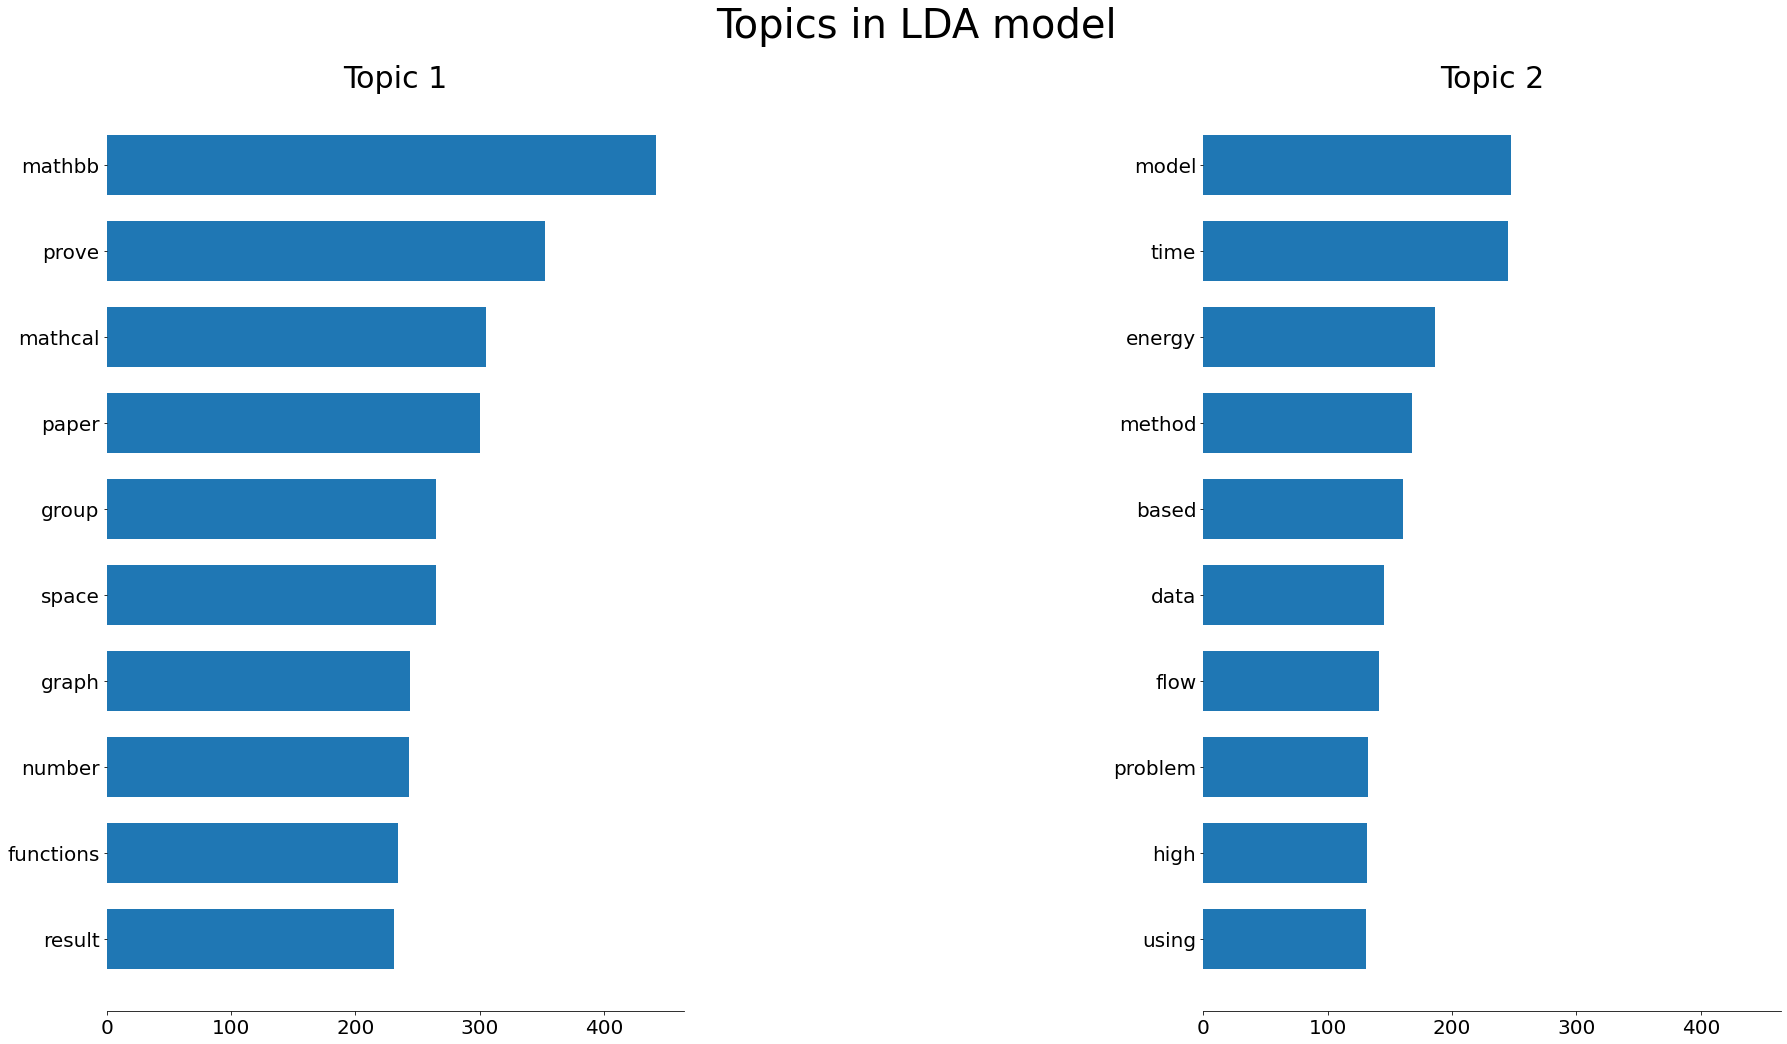

In [24]:
plot_top_words(lda, feature_names, n_top_words, "Topics in LDA model")

In [74]:
# split into train and test
train, test = train_test_split(sample_df, random_state=76, test_size=0.15, shuffle=True)

X_train = train.abstract
X_test = test.abstract

print(X_train.shape)
print(X_test.shape)

(21423,)
(3781,)


In [75]:
test.to_json('validation.json')

In [76]:
X_test

8857       Let $N(\sigma,T)$ denote the number of nontr...
3662       The free electron model with Boltzmann stati...
11067      We exhibit a new decomposition of the nonlin...
2911       We exploit a recently developed funnel contr...
5529       We investigate which higher rank simple Lie ...
                               ...                        
1761       Let $\gamma_{-1}$ be the absolutely continuo...
8506       In continuation of the paper [3], we discuss...
13840      The superspace ring $\Omega_n$ is a rank $n$...
10846      In this article, we give a new class of auto...
24850      This work looks at the theory of octonionic ...
Name: abstract, Length: 3781, dtype: object